## Import packages

In [1]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import larry
import sklearn.metrics
import glob
import cellplots as cp
import ABCParse

from typing import Optional, List

import matplotlib.cm as cm


import sklearn.preprocessing
import sklearn.decomposition
import seaborn as sns
import scipy.stats

import ABCParse
import numpy as np
import anndata
from annoyance import kNN

from typing import Optional

## Load data

LARRY dataset ground truth: `F_obs` (`pd.DataFrame`)

In [27]:
F_obs = larry.tasks.fate_prediction.F_obs

In [7]:
adata = anndata.read_h5ad("/home/mvinyard/data/adata.LARRY_train.19MARCH2024.h5ad")
X = adata[adata.obs['train']].X.toarray()

## Define helper classes and functions

In [15]:
class ConfigureR(ABCParse.ABCParse):
    def __init__(
        self,
        adata: anndata.AnnData,
        source_sink_col: str = "Cell type annotation",
        baseline: float = -1.0e-03,
        *args,
        **kwargs,
    ):

        self.__configure__(locals())

    def __configure__(
        self, kwargs, ignore=["self"], private=["adata", "source_sink_col"]
    ):

        self.__parse__(kwargs=kwargs, ignore=ignore, private=private)

        self._df = self._adata.obs.copy()
        self._grouped = self._df.groupby(self._source_sink_col)
        self.R = np.zeros(len(self._adata)) + self._baseline

    def _as_list(self, key):
        if not isinstance(key, list):
            return list(key)
        else:
            return key

    def _configure_sinks_not_provided(self, sink_key):
        if not sink_key:
            self._sinks = [
                key for key in list(self._grouped.groups.keys()) if not key == self._source_key
            ]
        else:
            self._sinks = self._as_list(sink_key)

    def configure_source(self, key="undiff", val=0.2):

        idx = self._df.loc[self._df[self._source_sink_col] == key].index.astype(int)
        self.R[idx] = val

    def configure_sink(self, key=None, val=-0.2):

        self._configure_sinks_not_provided(key)

        for annot, annot_df in self._grouped:
            idx = annot_df.index.astype(int)
            if annot in self._sinks:
                self.R[idx] = val

    def __call__(
        self,
        source_key: str = "Undifferentiated",
        source_val: float = 0.2,
        sink_key: Optional[str] = None,
        sink_val: float = -0.2
    ):
        
        self.__parse__(locals())

        self.configure_source(source_key, source_val)
        self.configure_sink(sink_key, sink_val)

        return self.R


def configure_R(
    adata: anndata.AnnData,
    source_sink_col: str = "Cell type annotation",
    baseline: float = -1.0e-03,
    source_key: str = "Undifferentiated",
    source_val: float = 0.2,
    sink_key: Optional[str] = None,
    sink_val: float = -0.2,
    key_added: str = "R",
):
    """
    
    """
        
    r_param = ConfigureR(
        adata=adata,
        source_sink_col=source_sink_col,
        baseline=baseline,
    )

    adata.obs[key_added] = r_param(
        source_key=source_key,
        source_val=source_val,
        sink_key=sink_key,
        sink_val=sink_val,
    )

In [67]:
class ConfigureS(ABCParse.ABCParse):
    def __init__(
        self,
        adata: anndata.AnnData,
        fate_key: str = "Cell type annotation",
        *args,
        **kwargs,
    ):

        self.__parse__(locals(), public = [None])
        self._configure_graph()
        self._grouped = self._adata.obs.groupby(self._fate_key)

    def _configure_graph(self):

        self.Graph = kNN(self._adata)
        self.Graph.build()

    def _configure_fates(self):
        if not hasattr(self, "_fates"):
            self._fates = self._adata.obs[self._fate_key].unique().tolist()
            self._adata.uns['fates'] = self._fates

    @property
    def fates(self):
        self._configure_fates()
        return self._fates

    @property
    def n_cells(self):
        return self._adata.shape[0]

    @property
    def n_fates(self):
        return len(self.fates)

    @property
    def S_init(self):
        return np.zeros([self.n_cells, self.n_fates])

    def __call__(self, sink_val=10, use_key="X_pca", potential_key="V"):

        # TODO-POTENTIALLY: supply a dict mapping fates to sink values

        self.S = self.S_init.copy()

        for n, fate in enumerate(self.fates):
            fate_df = self._grouped.get_group(fate)
            # requires a consistent index (no subsetting adata without resetting index)
            nn_idx = self.Graph.query(
                self._adata[fate_df[potential_key].idxmin()].obsm[use_key]
            ).flatten()
            sink_idx = self._adata[nn_idx.flatten()].obs.index.astype(int)
            self.S[sink_idx, n] = sink_val

        return self.S
    
def configure_S(
    adata: anndata.AnnData,
    fate_key: str = "Cell type annotation",
    sink_val: float = 10,
    use_key: str = "X_pca",
    potential_key: str = "V",
    key_added: str = "S",
    *args,
    **kwargs,
):
    """
    Configure S.
    """

    s_config = ConfigureS(adata = adata, fate_key=fate_key)
    adata.obsm[key_added] = s_config(
        sink_val=sink_val, use_key=use_key, potential_key=potential_key
    )

## Downsample `adata`

In [83]:
adata_ds = adata[sample_ix].copy()

## Configure `R`, `S`

Per-cell `R` and `S` terms of `PBA`

In [124]:
s_config = ConfigureS(adata = adata_ds, fate_key="Cell type annotation")
adata_ds.obsm["S"] = s_config(
    sink_val="10", use_key="X_pca", potential_key="V"
)

/tmp/ipykernel_785227/3205581843.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._grouped = self._adata.obs.groupby(self._fate_key)


In [73]:
configure_R(adata)

/tmp/ipykernel_785227/629527030.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._grouped = self._df.groupby(self._source_sink_col)


In [78]:
R = adata[sample_ix].obs['R']

### Load the inverted Laplacian matrix

In [72]:
Linv = np.load("./Linv.npy")

In [94]:
V = np.dot(Linv, R)
np.save("./run_pba/V.npy", V)
adata_ds.obs['V'] = V
V.shape

(20000,)

In [96]:
B = np.load("./run_pba/B.npy")
adata_ds.obsm['B'] = B
B.shape

(20000, 11)

In [105]:
fate_pred = adata_ds[adata_ds.obs['index'].isin(F_obs.index)].obsm['B']
fate_pred.shape

(2081, 11)

In [655]:
PBA_F_hat = pd.DataFrame(fate_pred, columns = s_config.fates)
PBA_F_hat.index = F_obs.index

In [660]:
PBA_F_hat = PBA_F_hat.drop("Undifferentiated", axis = 1).copy()

In [669]:
PBA_F_hat = PBA_F_hat.div(PBA_F_hat.sum(1), axis = 0)

In [670]:
any(PBA_F_hat.sum(1)==0)

False

### Accuracy score: prediction of dominant fate

In [672]:
larry.tasks.fate_prediction.metrics.multi_idx_accuracy(F_obs, PBA_F_hat)

,accuracy
all,0.399327
unique_train.N/M,0.513699
unique_train.N/M-early,0.416290
unique_train.all_fates,0.412420
unique_test.N/M,0.467033
unique_test.N/M-early,0.402256
unique_test.all_fates,0.363213


### Neu/Mon correlation

In [680]:
test_set = larry.tasks.fate_prediction.weinreb_test_set(adata)

In [703]:
ix = larry.tasks.fate_prediction.InVitroFatePredictionSubsets().indices["unique_test"][
    "N/M-early"
]

In [709]:
PBA_F_hat_nm = PBA_F_hat.loc[ix].copy() # test_set.index
# F_obs_nm = F_obs.loc[ix]
F_obs_nm = F_obs.loc[test_set.index]

In [710]:
y_pred = PBA_F_hat_nm['Neutrophil'].div(PBA_F_hat_nm[['Neutrophil', 'Monocyte']].sum(1))
y_true = F_obs_nm['Neutrophil'].div(F_obs_nm[['Neutrophil', 'Monocyte']].sum(1))

In [712]:
scipy.stats.pearsonr(y_true, test_set['PBA'])

PearsonRResult(statistic=0.16236666411029574, pvalue=0.0028778593558526785)

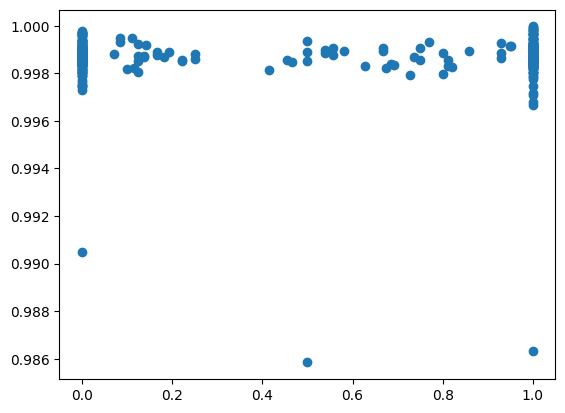

In [697]:
plt.scatter(y_true, y_pred)